# ELEC 400M / EECE 571M Assignment 2: Neural networks
(This assignment is a modified version of an assignment used in ECE 421 at the University of Toronto and kindly made available to us by the instructor.)

In this assignment, you will implement a neural network model for multi-class classification. The purpose is to demonstrate an understanding of the basic elements including training of neural network models. Hence, your implementation will be from scratch only using functions from the NumPy library.

The neural network you will be implementing has the following structure:
* 3 layers: 1 input layer, 1 hidden layer with ReLU activation and 1 output layer with Softmax function 􏴣 
* The loss function is the Cross Entropy Loss.
* Training will be done using Gradient Descent with Momentum. 

## Data Set
We again consider the dataset of images of letters in different fonts contained in file notMNIST.npz (which btw is from http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html). This time we consider 10 letters ("A" to "J"), which are all the letters contained in this data set, and we want to classfiy the images according to the letter they display. The figure below shows 30 randomly selected image samples for the letters.

![](sample_images_2.eps)


You will apply the function `loadData` given below to load the data set, which includes 18720 images and their labels, which we also refer to as targets. This script organizes the data set into training, validation and test sets. 

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def loadData():
    with np.load('notMNIST.npz') as data:
        Data, Target = data['images'], data['labels']
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx]/255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
       
    return trainData, validData, testData, trainTarget, validTarget, testTarget

## Data preprocessing [5 points]

Input data: The classification should be based on the $d=28\times 28=784$ intensity values in an image (as for Assignment 1).

Output data: Since you will be performing multi-class classification, the labels will be converted into a one-hot encoding format. 

Please first briefly explain the meaning of one-hot encoding and why it is used (instead of keeping the numerical label values provided by the data set). State an example for a one-hot encoded label for the data set considered in this assignment.

**One-hot encoding:**
One-hot encoding assigns the categorical class labels with their own vector and gives them a value of 1 or 0. The length of these vectors is equal to the number of classes or categories the model is expected to classify. As a result, the more variables in a column will now correspond with how often the variable appears in the vector. 
Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric. This means that categorical data must be converted to a numerical form. By using one hot encoding we’re encoding our labels with an integer or a vector of integers, specifically a 1 or 0. Thus, giving our models data it can process.

**Reason for using one-hot encoding:**
For categorical variables where no such ordinal relationship exists, the integer encoding allows the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories). Assigning a higher value to a variable when none exist can throw off the model. Learning would tend to accommodate such a variance even if it was artificial. Using one-hot encoding for the different classes eliminates the ordinality between the labels and thus avoids the problem.

**For example**, in this assignment the 10 classes ‘A’ to ‘J’ has ordinal categorical values from 0 – 9. After one hot encoding the labels the values of the labels are converted into vectors of length 10 and only one bit with value 1. So ‘A’ is represented as “0000000001” and ‘J’ as “1000000000”.

Now implement a function that one-hot encodes the labels (or targets) for the training, validation and test sets. 

In [5]:
def convertOneHot(trainTarget, validTarget, testTarget):
    #function for converting to one hot
    def one_hot(targets, n):
        out = np.eye(n)[np.array(targets).reshape(-1)]
        return out.reshape(list(targets.shape)+[n])
    trainTarget_onehot = one_hot(trainTarget,10)
    validTarget_onehot = one_hot(validTarget,10)
    testTarget_onehot = one_hot(testTarget,10)
    return trainTarget_onehot, validTarget_onehot, testTarget_onehot

## Structure of the network [2 points]

Sketch the structure of the network to classify the letters from the data set. Identify the dimensions of the network layers, include the activation functions, and do not forget the bias nodes. (You may sketch this by hand and upload a photo of your sketch.)

![NN.png](Images/NN.png)


## Helper functions [6 points]
To give the implementation of the network some structure, you will first implement five helper functions. 

Use Numpy arrays for your implementations, and organize data in vectors and matrices as appropriate for compact programming.

1. `relu`: This function will accept one argument and return the ReLU activation: 
    $$\mathrm{ReLU}(x)=\max(0,x).$$
    
2. `softmax`: This function will accept one argument and return the softmax activations:
    $$ [\sigma(\mathbf{z})]_j = \frac{\mathrm{e}^{z_j}}{\sum\limits_{k=1}^K\mathrm{e}^{z_k}},$$ $j=1,2,\ldots, K$,  for $K$ classes.

3. `computeLayer`: This function will accept two arguments, the input vector $\mathbf{x}$ for a layer and the weight matrix $\mathbf{W}$, and return a vector $\mathbf{s}=\mathbf{W}^T\mathbf{x}$, i.e., the input to the activation function of the layer (the notation for variables from the textbook is used). Don't forget to account for the bias term (which can be included in an augmented vector $\mathbf{x}$ as in the textbook).

4. `CE`: This function will accept two arguments, the one-hot encoded labels $\mathbf{y}_n$ and the inputs $\mathbf{s}_n$ to the softmax function, $n=1,2,\ldots N$. It will return the cross entropy loss
$$\mathrm{E}_{\mathrm{in}}=-\frac{1}{N}\sum\limits_{n=1}^N\sum\limits_{k=1}^Ky_{n,k}\log([\sigma(\mathbf{s}_n)]_k)$$

5. `gradCE`: This function will accept two arguments, the labels and the inputs to the softmax function. It will return the gradient of the cross entropy loss with respect to the inputs (i.e., it returns the sensivity vector for the output layer as introduced in the textbook). 

First state the analytical expression for the gradient used in `gradCE` and then implement the five helper functions.

**Answer:**

The sensitivity vector for the output layer is a simple expression which is the difference between the predicted value and the labels.

$\frac{\partial{E_{in}}}{\partial{s^L\ }}=\ {\theta(s}^L)\ -\ y$

where $\theta$ is the softmax activation function and *y* is the label



In [6]:
def relu(x):
    return np.maximum(x, 0)

In [7]:
def softmax(x):    
    exp = np.exp(x)
    return exp/np.sum(exp, axis = 1, keepdims = True)

In [8]:
def computeLayer(x,W):
    s = np.dot(x,W)
    return s

In [9]:
def CE(target, prediction):
    epsilon=1e-22 #Small value to avoid runtime errors in log function
    prediction = softmax(prediction)
    prediction = np.clip(prediction, epsilon, 1. - epsilon)
    N = prediction.shape[0]
    ce = -np.sum(target*np.log(prediction+1e-22))/N
    return ce

In [10]:
def gradCE(target, prediction):
    grad = softmax(prediction) - target
    return grad

## Backpropagation [2 points]

The training of the network will be done via backpropagation. First derive the following gradients:
1. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{o}}}$, where $\mathbf{W}^{\mathrm{o}}$ is the weight matrix of the output layer.

2. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{h}}}$, where $\mathbf{W}^{\mathrm{h}}$ is the weight matrix of the hidden layer.

Write the results using the steps and notation used in the textbook.

To find the above gradients chain rule has to be used
1. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{o}}}$ - The gradient of the loss with respect to the outer layer weights.  $\theta$ denotes the activation function

    $\frac{\partial{e}}{\partial{w_{i,j}^o}}=\ \frac{\partial{s_j^o}}{\partial{w_{i,j}^o}}\ \frac{\partial{e}}{\partial{s_j^o}}$
    
    $\frac{\partial{e}}{\partial{w_{i,j}^o}}=\ x_i^h\ .\ \ \delta_j^o$
    
    $\delta_j^o\ =\ \frac{\partial{e}}{\partial{s_j^o}}\ =\ \ {\theta(s}^o)\ – y$   *(Sensitivity vector of output layer from above equation in gradCE )*
    
    $\frac{\partial{E_{in}}}{\partial{W^o}}\ =\ {\ {(x}^h)}^T.\ (\ {\theta(s}^o)\ – y)$
-----------------------------------
   
2. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{h}}}$ - The gradient of the loss with respect to the hidden layer weights.  $\theta$ denotes the activation function

$\frac{\partial{e}}{\partial{w_{i,j}^h}}=\ \frac{\partial{s_j^h}}{\partial{w_{i,j}^h}}\ \frac{\partial{e}}{\partial{s_j^h}}$

$\frac{\partial{e}}{\partial{w_{i,j}^h}}=\ x_i^{in}.\ \ {{(\delta}^h)}^T$

To find the sensitivity of  the hidden layer, we again use chain rule

$\delta^h\ =\ \frac{\partial{e}}{\partial{s_j^h}}\ \ \ =\ \frac{\partial{e}}{\partial{x_j^h}}\ \ \frac{\partial{x_j^h}}{\partial{s_j^h}}$

$\delta^h\ =\ \theta^{'}{(s^h)}\ .\ \frac{\partial{e}}{\partial{x_j^h}}$

- $\theta^{'}{(s^h)}\ = 0$ if x <= 0 

- $\theta^{'}{(s^h)}\ = 1$ if x > 0    *(Derivative of Relu function)*

$\frac{\partial{e}}{\partial{x^h}}\ =\ \ (\ {\theta(s}^o)\ – y) .   (W^o)^T$

Combining the above two equations the sensitivity of  the hidden layer is as follows

$\delta^h\ =\ \theta^{'}{(s^h)}\ .\ (\ {\theta(s}^o)\ – y) .   (W^o)^T$

Thus, the gradient of the loss with respect to the hidden layer weights

$\frac{\partial{E_{in}}}{\partial{W^h}}\ =\ \ {(x^{in})}^T.\ \delta^h$

The final expression is:

$\frac{\partial{E_{in}}}{\partial{W^h}}\ =\ \ {(x^{in})}^T\ \otimes\ \theta^{'}{(s^h)}\ .\ (\ {\theta(s}^o)\ – y) .  (W^o)^T$

## Network training [8 points]

Implement a function to train the network. The function uses the helper functions from above. The optimization technique for backpropagation will be Gradient Descent with Momentum:
$$\mathbf{V}(t)=\alpha \mathbf{V}(t-1)-\eta\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}(t)}$$
and 
$$\mathbf{W}(t+1)=\mathbf{W}(t)+\mathbf{V}(t),$$
where $\eta$ is the learning rate and $\alpha$ is the momentum hyperparameter.

The training function accepts the following inputs:  training data (features), training labels, weight matrix of the hidden layer, weight matrix of the output layer, number of iterations, parameters $\eta$ and $\alpha$, validation data, validation labels, test data, test labels. The validation and test inputs are initialized to "None" and need not be passed on. You will also need to initialize the velocity matrices $\mathbf{V}$ for both hidden layer and output layer weights to small values, e.g. $10^{-5}%$.

The function outputs the updated weight matrices, the losses and classification accuracies for the training data, and if validation and test inputs were provided, then it also outputs the classification accuracies for the validation and test data.

In [11]:
# loading data
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

# Converting integer labels to to one-hot encoded labels
trainTarget, validTarget, testTarget = convertOneHot(trainTarget, validTarget, testTarget)

def gradRelU(x):
    return np.where(x <= 0, 0, 1)

def Train(trainData, trainTarget, wh, wbo ,wo, epochs, eta, momentum,
          validData, validTarget, testData, testTarget):
    
    print('*********Training has begun*********')
    
    # Initialize the momentum matrices

    vh = np.ones(wh.shape)
    vbo = np.ones(wbo.shape)
    vo = np.ones(wo.shape)
    
    vh = np.multiply(vh,1e-5)
    vbo = np.multiply(vbo,1e-5)
    vo = np.multiply(vo,1e-5)   
     
    def ForwardProp(data_in, wo, wbo, wh):
        sh = computeLayer(data_in, wh)   
        xh = relu(sh)            
        so = computeLayer(xh, wo) + wbo     
        xo = softmax(so)         
        return sh, xh, so, xo
    
    def gradients(data_in, labels, sh, xh, xo, wo):
    #    N = labels.shape[0]
        N = 1  #    Update N = 1 according to update in Piazza post for proper results
        wo_grad = (1 / N) * np.dot(xh.T, gradCE(labels, so))  
        wbo_grad = (1 / N) * np.sum(gradCE(labels, so), axis=0) 
        senitivityHidden = np.multiply(gradRelU(sh), np.dot(gradCE(labels, so), wo.T))
        wh_grad = (1 / N) * np.dot(data_in.T, senitivityHidden)
        return wo_grad, wbo_grad, wh_grad
    
    
    def updateWt(preVel, Wt, momentum, eta, grad):
        #Update velocity vector and add to weights
        vel = momentum * preVel - eta * grad
        Wt = Wt + vel
        return Wt, vel
    
    def Accuracy(predictions, labels):    
        correct = 0
        total = 0
        for i in range(len(predictions)):
            act_label = np.argmax(labels[i]) # act_label = 1 (index)
            pred_label = np.argmax(predictions[i]) # pred_label = 1 (index)
            if(act_label == pred_label):
                correct += 1
            total += 1
        accuracy = (correct/total)*100
        return accuracy
    
    
    trainingLoss_curve = []
    trainingAccu_curve = []
    validLoss_curve = []
    validAccu_curve = []
    testAccu_curve = []
    testloss_curve = []    
    
    
    for epoch in range(epochs):
    
        # Forward Propagation
    
        sh, xh, so, xo = ForwardProp(trainData, wo, wbo, wh)
        wo_grad, wbo_grad, wh_grad = gradients(trainData, trainTarget, sh, xh, xo, wo)
    
        # Weight matrix update
    
        wo, vo = updateWt(vo, wo, momentum, eta, wo_grad)
        wbo, vbo = updateWt(vbo, wbo, momentum, eta, wbo_grad)
        wh, vh = updateWt(vh, wh, momentum, eta, wh_grad)
    
        # CE losses and Classification accuracies calculation
    
        trainingAccu  = Accuracy(ForwardProp(trainData, wo, wbo, wh)[3], trainTarget) 
        #3rd indexed Output of ForwardProp is the predicted value
        trainingAccu_curve.append(trainingAccu)
        trainingLoss = CE(trainTarget, ForwardProp(trainData, wo, wbo, wh)[2])
        #2nd indexed Output of ForwardProp is the input to the softmax layer
        trainingLoss_curve.append(trainingLoss)
                
        validAccu = Accuracy(ForwardProp(validData, wo, wbo, wh)[3], validTarget)
        validAccu_curve.append(validAccu)
        validLoss = CE(validTarget, ForwardProp(validData, wo, wbo, wh)[2])
        validLoss_curve.append(validLoss)

        testAccu = Accuracy(ForwardProp(testData, wo, wbo, wh)[3], testTarget)
        testAccu_curve.append(testAccu)
        testloss = CE(testTarget, ForwardProp(testData, wo, wbo, wh)[2])
        testloss_curve.append(testloss)
    
        
        print('Epoch:' ,epoch + 1, '|Training loss:', trainingLoss, 'Validation loss:',validLoss,'Test loss:',testloss,'\n', 
              'Training Accuracy:',trainingAccu,'%','Validation Accuracy:',validAccu,'%','Test Accuracy:',testAccu,'%')
    print('=============Training has ended=============\n\n')  
    print('Final Loss after training','\n_____________________________','\nTraining:',trainingLoss,'\nValidation:',validLoss,'\nTest:',testloss)
    print('\nFinal Accuracies after training','\n_____________________________','\nTraining:',trainingAccu,'\nValidation:',validAccu,'\nTest:',testAccu)
    
    
    #Ploting Loss curves        
    plt.plot(trainingLoss_curve)
    plt.plot(validLoss_curve)
    plt.plot(testloss_curve)
    plt.legend(['training', 'validation', 'test'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Number of epochs')
    plt.show()
    
    #Ploting Accuracy curves 
    
    plt.plot(trainingAccu_curve)
    plt.plot(validAccu_curve)
    plt.plot(testAccu_curve)
    plt.legend(['training', 'validation', 'test'])
    plt.xlabel('Epochs')
    plt.ylabel('Classification accuracy')
    plt.title("Classification Accuracy vs Number of epochs")
    plt.show()
    
    return wo, wbo, wh, trainingLoss, validLoss, testloss, trainingAccu, validAccu, testAccu

## Network test [4 points]

Write a script that constructs the neural network.

Initialize your weight matrices by drawing the elements i.i.d. at random from a zero-mean Gaussian distribution with variance equal to $$\sigma_w^2=\frac{2}{\mbox{# of input nodes + # of output nodes}}$$ (Xavier normalization http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 

Build a network with 1000 hidden units and train it for 200 epochs using $\alpha=0.9$ and $\eta=10^{-5}$. Plot the training, validation and testing accuracy curves. State the training, validation and testing accuracies after training. Show the plot and the accuracies in the next markdown cell.

*********Training has begun*********
Epoch: 1 |Training loss: 2.559013913923701 Validation loss: 2.5459103655065163 Test loss: 2.541114097382972 
 Training Accuracy: 29.406666666666663 % Validation Accuracy: 30.2 % Test Accuracy: 29.845814977973568 %
Epoch: 2 |Training loss: 2.147789486078638 Validation loss: 2.203268765385666 Test loss: 2.150405681736907 
 Training Accuracy: 43.18666666666667 % Validation Accuracy: 42.4 % Test Accuracy: 43.68575624082232 %
Epoch: 3 |Training loss: 1.4407338842332302 Validation loss: 1.495377860886723 Test loss: 1.4378288237160028 
 Training Accuracy: 53.82 % Validation Accuracy: 51.6 % Test Accuracy: 53.377386196769464 %
Epoch: 4 |Training loss: 0.8830211116393378 Validation loss: 0.8830424589042681 Test loss: 0.8798623161451409 
 Training Accuracy: 73.81333333333333 % Validation Accuracy: 75.8 % Test Accuracy: 75.47723935389133 %
Epoch: 5 |Training loss: 1.0826374869911504 Validation loss: 1.0743855041863557 Test loss: 1.0695528700173367 
 Training A

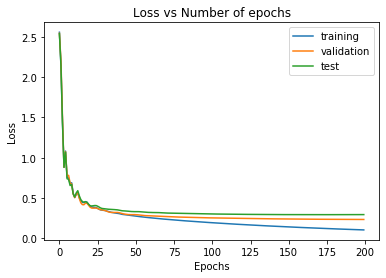

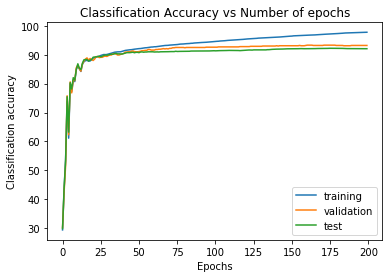

In [12]:
def NeuralNetwork(trainData, trainTarget, HiddenNeurons, epochs, eta, momentum,
          validData, validTarget, testData, testTarget):
    
        # Xavier Init
        # where sigma^2 = (2 / (#inputNodes + #outputNodes), mean = 0
        wo = np.random.normal(0, np.sqrt(2/(HiddenNeurons + 10)), (HiddenNeurons, 10))
        wbo = np.zeros((1, 10))
        wh = np.random.normal(0, np.sqrt(2/(785 + HiddenNeurons)), (785, HiddenNeurons))
        
        #Calling the train function
        wo, wbo, wh, trainingLoss, validLoss, testloss, trainingAccu, validAccu, testAccu = Train(trainData, trainTarget, wh, wbo ,wo, epochs, eta, momentum,
          validData, validTarget, testData, testTarget)

# Reshape the input data
def Reshape(z):        
        a = []
        for i in range(len(z)):
            z[i] = np.array(z[i])
            b = z[i].flatten()
            b = [1,*b]
            b = np.asarray(b)
            a.append(b)
        a = np.asarray(a)
        return a
    
trainData = Reshape(trainData)
validData = Reshape(validData)
testData = Reshape(testData) 

NeuralNetwork(trainData, trainTarget, 1000, 200, 1e-5, 0.9,
          validData, validTarget, testData, testTarget)

Neural Net with 784 input nodes, 1000 hidden nodes and 10 output nodes. Hidden layer with ReLu activation and output layer with Softmax activation.

Hyperparameters:
* Hidden nodes = 1000
* Learning rate = 0.00001
* momentum = 0.9
* Epochs = 200

Final Loss after training  
* Training: 0.10288799077277139 
* Validation: 0.23266862756407947 
* Test: 0.29319878056307447

Final Accuracies after training
* Training: 97.76666666666667%
* Validation: 93.2% 
* Test: 92.07048458149781%

![1_loss.png](Images/1_loss.png)
![1_accu.png](Images/1_accuracy.png)

## Hyperparameter investigation [3 points]

Continue to use $\alpha=0.9$ and $\eta=10^{-5}$.

Test your network with 500, 1500, 2500 hidden nodes and train for 200 epochs. Comment based on the validation accuracy after how many epochs training could be terminated early. 

Plot the training and validation accuracy curves for all three network sizes and 200 training epochs, and report the test accuracy for your selected network size and training length. Show the plot and the accuracies in the next markdown cell.

(Training of the large network for 200 epochs should take about 30-60 mins.)


**************************************Results when Hidden Layers = 500 **************************************

*********Training has begun*********
Epoch: 1 |Training loss: 2.4032920548564967 Validation loss: 2.468392103114566 Test loss: 2.421126253643751 
 Training Accuracy: 30.046666666666667 % Validation Accuracy: 29.9 % Test Accuracy: 29.88252569750367 %
Epoch: 2 |Training loss: 2.089415618334195 Validation loss: 2.1395996235110193 Test loss: 2.123124208043636 
 Training Accuracy: 51.77333333333334 % Validation Accuracy: 52.1 % Test Accuracy: 52.23935389133627 %
Epoch: 3 |Training loss: 1.3147393883137706 Validation loss: 1.360475668787461 Test loss: 1.3336131245504608 
 Training Accuracy: 64.69333333333334 % Validation Accuracy: 64.7 % Test Accuracy: 65.12481644640235 %
Epoch: 4 |Training loss: 1.0462845828546574 Validation loss: 1.0585905692346769 Test loss: 1.0246039422685456 
 Training Accuracy: 63.89333333333334 % Validation Accuracy: 63.1 % Test Accuracy: 65.01468428781205 %

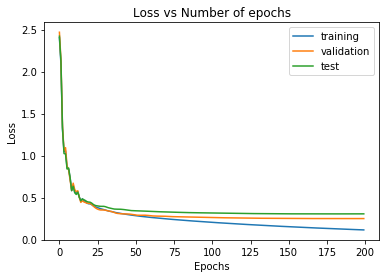

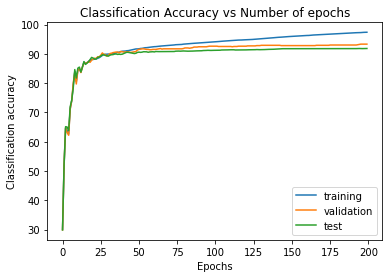


**************************************Results when Hidden Layers = 1500 **************************************

*********Training has begun*********
Epoch: 1 |Training loss: 2.260778943292381 Validation loss: 2.2560889740729015 Test loss: 2.2770447671681993 
 Training Accuracy: 29.599999999999998 % Validation Accuracy: 28.499999999999996 % Test Accuracy: 28.597650513950075 %
Epoch: 2 |Training loss: 1.9981964471436546 Validation loss: 2.023497658100364 Test loss: 1.9458826372438298 
 Training Accuracy: 58.38666666666666 % Validation Accuracy: 58.5 % Test Accuracy: 59.471365638766514 %
Epoch: 3 |Training loss: 1.5906114432398193 Validation loss: 1.6479150016202693 Test loss: 1.5273395898363897 
 Training Accuracy: 60.333333333333336 % Validation Accuracy: 59.599999999999994 % Test Accuracy: 61.710719530102786 %
Epoch: 4 |Training loss: 0.9436813732532721 Validation loss: 0.9672232597111248 Test loss: 0.9039891709906558 
 Training Accuracy: 71.02000000000001 % Validation Accuracy: 70.3 

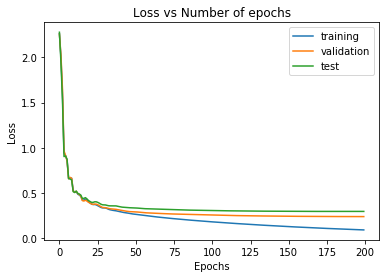

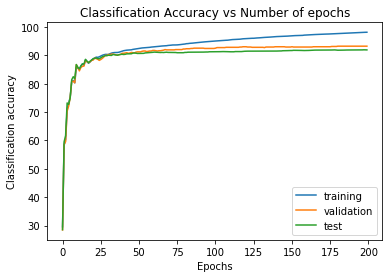


**************************************Results when Hidden Layers = 2500 **************************************

*********Training has begun*********
Epoch: 1 |Training loss: 2.0937471641543888 Validation loss: 2.1270579100793667 Test loss: 2.0688177398488237 
 Training Accuracy: 31.546666666666667 % Validation Accuracy: 31.5 % Test Accuracy: 32.59911894273127 %
Epoch: 2 |Training loss: 1.6680043497854133 Validation loss: 1.7368041323890098 Test loss: 1.6590842838874391 
 Training Accuracy: 54.333333333333336 % Validation Accuracy: 54.0 % Test Accuracy: 54.66226138032305 %
Epoch: 3 |Training loss: 0.9838916079920295 Validation loss: 0.9859279762159865 Test loss: 0.9663305549223323 
 Training Accuracy: 63.85333333333333 % Validation Accuracy: 64.0 % Test Accuracy: 65.45521292217327 %
Epoch: 4 |Training loss: 1.350914115467037 Validation loss: 1.361582789881959 Test loss: 1.3409461111976948 
 Training Accuracy: 57.26 % Validation Accuracy: 57.49999999999999 % Test Accuracy: 56.2775330396

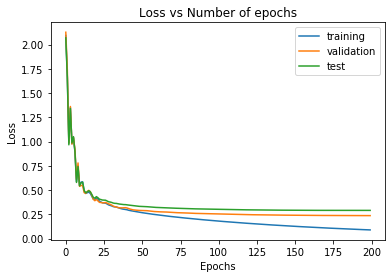

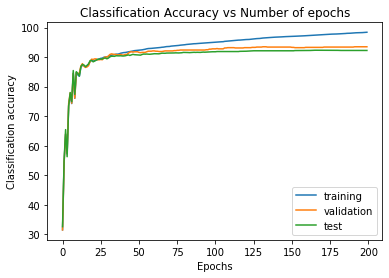

In [15]:
print('\n**************************************Results when Hidden Layers = 500 **************************************\n')
NeuralNetwork(trainData, trainTarget, 500, 200, 1e-5, 0.9,
          validData, validTarget, testData, testTarget)
print('\n**************************************Results when Hidden Layers = 1500 **************************************\n')
NeuralNetwork(trainData, trainTarget, 1500, 200, 1e-5, 0.9,
          validData, validTarget, testData, testTarget)
print('\n**************************************Results when Hidden Layers = 2500 **************************************\n')
NeuralNetwork(trainData, trainTarget, 2500, 200, 1e-5, 0.9,
          validData, validTarget, testData, testTarget)

**500 Hidden Nodes:**
    
Peak Accuracy for validation set is 93.3% which is achieved at **194th** epoch and remains at the same accuracy from then on. The training could be terminated early at 194th epoch. The early stopping could be found when the accuracy of the validation data has reached its highest value.

Final Loss after training 
* Training: 0.11527319821899291  
* Validation: 0.25039832438737003  
* Test: 0.30652843456683176
    
Final Accuracies after training  
* Training: 97.36 % 
* Validation: 93.30000000000001%
* Test: 91.81350954478708%
 ![Loss500.png](Images/Loss500.png)![Accu500.png](Images/Accu500.png)
    

**1500 Hidden Nodes:**
Peak Accuracy for validation set is 93.2% which is achieved at **179**th hence the training could be terminated early at 179th epoch. 

Final Loss after training
* Training: 0.09406820597596835 
* Validation: 0.2411757797566447  
* Test: 0.2984836435273976

Final Accuracies after training 
* Training: 98.10666666666667%
* Validation: 93.2%  
* Test: 91.88693098384728%
    ![Loss1500.png](Images/Loss1500.png)![Accu1500.png](Images/Accu1500.png)
    


**2500 Hidden Nodes:**
    
Peak Accuracy for validation set is 93.5% which is achieved at **192**nd epoch. The training could be terminated early at this epoch. 

Final Loss after training 
* Training: 0.088942048464354  
* Validation: 0.23639512122150336 
* Test: 0.29028134848257964

Final Accuracies after training 
* Training: 98.42% 
* Validation: 93.5% 
* Test: 92.25403817914831%
![Accu2500.png](Images/Accu2500.png)![Loss2500.png](Images/Loss2500.png)

**Inference:** 
* It can be noticed that as number of hidden nodes increases, the training accuracy increases but not the validation accuracies. 
* Increasing the number of hidden nodes not only increases the execution time but also results in overfitting the model.
* With respect to validation accuracy all three models have almost same accuracy of (93.3, 93.2, 93.5)%. With respect to Test accuracies, model with 2500 nodes has largest value of **92.25%**.

Hence considering the validation and test accuracies and execution time, the model with 500 nodes works the best in this classification problem.
